# Final Project

### Jinchen Zou
### Jonathan Ho
### Nathan Chau
### Shaival Divatia

## Introduction and Background

Basketball is one of the most popular sports in the United States and is filled with passionate fans who care about their teams. Paired together with a very well known social media platform Twitter, these fans can express how they feel about their favorite players and the players they wish to see lose. We wanted to find out what fans thought about cerain basketball players, but we also wanted to know how these people's general opinions changed as they won or lost their games.

We will create our own dataset by pulling tweets from twitter. We found a previous project that asked if an NBA player’s performance in All Star voting could be predicted based on twitter sentiment. For each player they recorded, they counted the player’s number of tweets and the ratio of positive tweets. Results indicated that there was a positive correlation between a player’s number of related tweets and their number of All Star votes. Adding a sentiment value weight to the tweets increased prediction accuracy. (https://link.springer.com/content/pdf/10.1007%2F978-3-319-01796-9_20.pdf)


We will be analyzing the sentinment of hundreds of tweets about Kevin Durant and Giannis Antetokounmpo. We will then compare the sentiment value of these tweets to their basketball game wins and losses. Fans generally have mixed feelings about Durant, and we expect this to be reflected in the sentiment value of his tweets. Many fans dislike Durant and the Warriors, so his sentiment value might be low even when they win. Antetokounmpo is generally liked by fans, and performs well in both wins and losses. We expect that his sentiment value will generally be high. 


## Question and Hypothesis

What is twitter’s overall sentiment about Kevin Durant and Giannis Antetokounmpo on days where their team wins vs days where their team loses? 

Expected Answer: The trend that we would expect to observe is that on days where the player’s team wins, the sentiment should be high (positive) and on days where their team loses the sentiment should be lower (negative).


In [1]:
!python -m pip install tweepy --user
!python -m pip install -U textblob --user
!python -m textblob.download_corpora

The directory '/home/jovyan/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/jovyan/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Requirement al

In [45]:
%matplotlib inline
#Imports
import tweepy
import os.path
import csv
import re
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from os import path
from datetime import datetime
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

The following variables are unique keys / tokens given to the developers so that they may access Twitter API. Twitter restricts the number of tweets that you can pull from their website by using 15 minute windows (source - https://developer.twitter.com/en/docs/basics/rate-limiting.html). The amount of tweets that we are able to pull is 900 according to Twitter's rate limits talbe (source - https://developer.twitter.com/en/docs/basics/rate-limits). We take into account Twitter's limitations by running the program 2 or 3 times each in three hour intervals. We try to pull tweets just before a basketball game starts, during the basketball game, and after the basketball game so that we can get the tweets that are the most relevant to the player's performance in the game.

In [3]:
# Variables that contains the user credentials to access Twitter API 
ACCESS_TOKEN = '1121130610334912512-JDGgQVfZ0oFYpDEJiqK47sNNggbtVq'
ACCESS_SECRET = 'f35YjmSmptgwX4GcQBthPwhCZQ7T8n1NLhJXzKrdlNDmL'
CONSUMER_KEY = 'mfYU6xUdDVQxKc6Mh3g9Aete4'
CONSUMER_SECRET = 'xkClZZPJYne6QS2JZLkEdZ6YztJjGdjIbZLjeY6pXqpNu66dUe'

# Setup tweepy to authenticate with Twitter credentials:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

# Create the api to connect to twitter with your creadentials
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, 
                 compression=True)
# ---------------------------------------------------------------------------------------------------------------------
# wait_on_rate_limit= True;  will make the api to automatically wait for rate limits
# to replenish wait_on_rate_limit_notify= True;  will make the api print a notification
# when Tweepy is waiting for
# rate limits to replenish
# ---------------------------------------------------------------------------------------------------------------------

The arrays kdHashtags and gaHashtags contain keywords that we search for when looking through the tweets that are provided by Twitter. We used keywords that specifically mention the players to filter out any other tweets that may be irrelevant. We avoided using the player's team name because tweets about the team may involve other players' performance rather than the specific player we are targeting. We then store these tweets into two separate array, one for each player. The final variable we have is used specify how many tweets we would like to search for. This variable helps prevent us from exceeding our rate limit.

In [4]:
#initializes list of hashtags / words to search.
kdHashtags = ["#KevinDurant", "Kevin Durant", "Kevin Durant's", "@KDTrey5",  "Durant", 
              "KD"]
gaHashtags = ["Giannis Antetokounmpo", "Giannis Antetokounmpo's", "@Giannis_An34",
              "Giannis", "Antetokounmpo's" ]

#list containing tweets about KD
kdTweets = []

#list containing tweets about GA
gaTweets = []

#Number of tweets we want to search for per element inside of the hastag list
numTweets = 20

When running these API calls we are not actually searching through every tweet on Twitter! Twitter actually extracts about 1% of tweets by grabbing the ones that were published between the 657th and the 666th millisecond (source - http://blog.falcondai.com/2013/06/666-and-how-twitter-samples-tweets-in.html). Below we have some functions that take care of Twitter API calls as well as some the calls we make to TextBlob to determine the sentiment value of the tweet. The function "SentimentOfTweet" retrieves the sentiment value and the subjectivity of a the string that is passed to it. The function "BayesSentiment" also retrieves the sentiment but returns the how positive and how negative a tweet is. The positive and negative value it returns will add up to 1 when added together so TextBlob uses the greater value to classify the tweet passed in as either "pos" or "neg". The last two functions both search for tweets but use different keywords to search for a specific player. 

In [5]:
'''returns sentiment of a given string'''
def SentimentOfTweet(string):
    return TextBlob(string.lower()).sentiment

'''returns sentiment of a given string'''
def BayesSentiment(string):
    return TextBlob(string.lower(), analyzer=NaiveBayesAnalyzer()).sentiment

'''returns list of words from tweets that contain query'''
def searchKDTweets(query, num):
    results = api.search(query, count = num)
    for s in results:
        kdTweets.append( s.text.lower() )
    return kdTweets

'''returns list of words from tweets that contain query'''
def searchGATweets(query, num):
    results = api.search(query, count = num)
    for s in results:
        gaTweets.append( s.text.lower() )
    return gaTweets

This part of our code uses all the previous parts to create a database in the form of a csv file. First we query through our keywords array and store the search results into another array corresponding to the player. We then open a file csv file or create one if it does not already exist. The first line of the file will contain the columns Tweet, Polarity, Subjectivity, Positivity, Negativity, Classification, and Date. We keep track of when the data was pulled so that we can coordinate the days the the player's team won with when that tweet was published. Before adding the tweet to the csv file we filter out certain strings that may alter the sentiment value incorrectly. All of our data is then nicely placed into the csv file to be later cleaned up even more.

In [6]:
Query for tweets about KD
for kdQuery in kdHashtags:
    searchKDTweets( kdQuery, numTweets)

'''Open or create csv file for KD data'''
with open('KD_Data.csv', 'a') as kd_file:
    kdwriter = csv.writer(kd_file, delimiter=',', quotechar='"', 
                          quoting=csv.QUOTE_MINIMAL)

    '''Create the names of each data column if this file is empty'''
    if( os.stat('KD_Data.csv').st_size == 0 ):
        kdwriter.writerow(['Tweet', 'Polarity', 'Subjectivity', 'Positivity',
                           'Negativity', 'Classification', 'Date'])

    '''For each tweet that is in kdTweets'''
    for tweet in kdTweets:

        '''Filter tweet'''
        tweet = tweet.replace('\n', ' ')
        tweet = tweet.replace('rt', '')
        tweet = re.sub(r"http\S+", "", tweet)

        '''Get sentiment data'''
        sentiment = SentimentOfTweet(tweet)
        bayes = BayesSentiment(tweet)

        '''Write to csv file'''
        kdwriter.writerow([tweet.encode('utf-8').strip(), sentiment.polarity,
                           sentiment.subjectivity, bayes.p_pos, bayes.p_neg,
                           bayes.classification, 
                           datetime.today().strftime('%Y-%m-%d')])

This following code does the same as the code above except it searches for tweets of the player Giannis Antetokounmpo.

In [7]:
#Query for tweets about GA
for gaQuery in gaHashtags:
    searchGATweets(gaQuery, numTweets)
    
    '''Open or create csv file for GA data'''
with open('GA_Data.csv', 'a') as ga_file:
    gawriter = csv.writer(ga_file, delimiter=',', quotechar='"',
                          quoting=csv.QUOTE_MINIMAL)

    '''Create the names of each data column if this file is empty'''
    if (os.stat('GA_Data.csv').st_size == 0):
        gawriter.writerow(['Tweet', 'Polarity', 'Subjectivity', 'Positivity',
                           'Negativity', 'Classification', 'Date'])

    '''For each tweet that is in gaTweets'''
    for tweet in gaTweets:

        '''Filter tweet'''
        tweet = tweet.replace('\n', ' ')
        tweet = tweet.replace('rt', '')
        tweet = re.sub(r"http\S+", "", tweet)

        '''Get sentiment data'''
        sentiment = SentimentOfTweet(tweet)
        bayes = BayesSentiment(tweet)

        '''Write to csv file'''
        gawriter.writerow([tweet.encode('utf-8').strip(), sentiment.polarity,
                           sentiment.subjectivity,
                           bayes.p_neg, bayes.classification,
                           datetime.today().strftime('%Y-%m-%d')])

## Dataset

Example snippet of one of our data sets in its raw csv format. It is formatted using the columns Tweet, Polarity, Subjectivity, Positivity, Negativity, Classification, and Date as previously described. You may notice that some of the tweets in our dataset are repeated. Also some of the values for the "Polarity" variable is 0. This is handleded in our data cleaning and discussed further into the report. 

Tweet	Polarity	Subjectivity	Positivity	Negativity	Classification	Date
i thought we were supposed to be on the same team! clearly king louis xvi doesn’t even care about his own people 🐍…	0.233333333333333	0.502777777777778	0.848983903068137	0.151016096931864	pos	
tag a knicks fan!🔥🔥  #nba #basketball #ballislife #balldontlienation #basketballneverstops #basketballislife…	0	0	0.0878774911358352	0.912122508864163	neg	
7 insane stats for the day-- april 26, 2019 -  #russellwestbrook #westbrick #nbaplayoffs2019…	-1	1	0.862361377446975	0.137638622553025	pos	
@latineuro: the final game coming #gospursgo 120 #milehighbasketball 103   #derozan #denvernuggets #nbanaespn #durant #basketball  #clip…	-0.2	0.7	0.297958821183979	0.70204117881602	neg	
you just goota make thos hoops #clippersnation  #durant  #louwilliams    #harrell  #lacvsgsw  #warriors…	0	0	0.468675206022018	0.531324793977982	neg	
i do not know what to say about #denvernuggets #hoops   #clippers   #nba #nbaplayoffs   #nba  #kevindurant  #nba…	0	0	0.38570549936685	0.61429450063315	neg	
the final game coming #gospursgo 120 #milehighbasketball 103   #derozan #denvernuggets #nbanaespn #durant…	-0.2	0.7	0.438776835846889	0.561223164153111	neg	
good game demar  #denvernuggets #nbanaespn #durant #basketball  #clippersnation  #durant  #louwilliams    #harrell…	0.15	0.5	0.405866317253938	0.594133682746062	neg	
despite the @warriors game 5 loss to @laclippers, #kevindurant finished the game with 45 points on 14 of 26 shootin…	-0.4	0.4	0.598714412400062	0.401285587599939	pos	
anyone interested in #kevindurant's house in #malibu? #nba #nbatwitter #warriors #maliburealestate…	0.25	0.5	0.351230857463683	0.648769142536318	neg	
kevin durant's (@kdtrey5) 2009-10 shot cha:  volume: extreme | p_100 (percentile) shot skill: good | p_79 efficie…	0.2875	0.8	0.24831988576953	0.75168011423047	neg	
@netszn: caris leve said kevin durant “is like a big brother” to him 👀 #kevindurant #brooklynnets	0	0.1	0.433507520159971	0.566492479840029	neg	
and then she said its time for . #clippersnation  #durant  #louwilliams    #harrell  #lacvsgsw  #warriors  #dame…	0	0	0.444198303816138	0.555801696183862	neg	
@dchinellato d'accordo sul rendimento dell'uomo "in missione"! #kevindurant 💪🏀🔝  però.. leggendo "qua e là"...  dur…	0	0	0.5	0.5	pos	
#espos #espn #ballislife #hoopmixtape #oveime #worldstar #worldstarhiphop #kevindurant #damianlillard #bball…	0	0	0.25	0.75	neg	
@netszn: caris leve said kevin durant “is like a big brother” to him 👀 #kevindurant #brooklynnets	0	0.1	0.433507520159971	0.566492479840029	neg	

## Data Cleaning / Pre-processing

Following the collection of all the data, we processed it and cleaned it up to be able to easily visualize the data measurments 
that would be important to us. We did this by converting the csv file we had into a data frame and then grabbing the average values for the various columns of data we had based on the date of the tweet. The code to do this is below.

In [8]:
import pandas as pd

# --------------- KD SECTION -----------------------

df = pd.read_csv("KD_Data_DATE.csv");
df.columns = ['Tweet','Polarity','Subjectivity','Positivity','Negativity',
              'Classification','Date']
df.set_index('Date');

# Recording the wins and losses for KD
k = dict()
k['2019-05-03'] = 'W'
k['2019-05-05'] = 'L'
k['2019-05-06'] = 'L'
k['2019-05-07'] = 'L'
k['2019-05-09'] = 'W'
k['2019-05-10'] = 'W'
k['2019-05-15'] = 'W'
k['2019-05-16'] = 'W'
k['2019-05-17'] = 'W'
k['2019-05-19'] = 'W'
k['2019-05-20'] = 'W'

kd_pos = dict()
kd_neg = dict()
kd_pol = dict()
kd_sub = dict()
kd_numtweets = dict()

# Totalling up info from each column into dictionary
for i,row in df.iterrows():
    date = row['Date']
    if (date in kd_pos):
        kd_pos[date] += float(row['Positivity'])
        kd_neg[date] += float(row['Negativity'])
        kd_pol[date] += float(row['Polarity'])
        kd_sub[date] += float(row['Subjectivity'])
        kd_numtweets[date] += 1
    else:
        kd_pos[date] = float(row['Positivity'])
        kd_neg[date] = float(row['Negativity'])
        kd_pol[date] = float(row['Polarity'])
        kd_sub[date] = float(row['Subjectivity'])
        kd_numtweets[date] = 1

# Averaging the totalled info by dividing by number of tweets
for date in sorted(kd_pos.keys()):
    kd_pos[date] /= float(kd_numtweets[date])
    kd_neg[date] /= float(kd_numtweets[date])
    kd_pol[date] /= float(kd_numtweets[date])
    kd_sub[date] /= float(kd_numtweets[date])

# Writing data to csv file
kd_sentiment = pd.DataFrame({'result': pd.Series(k), 
                             'pos_sentiment': pd.Series(kd_pos),
                             'neg_sentiment': pd.Series(kd_neg),
                             'polarity': pd.Series(kd_pol),
                             'subjectivity': pd.Series(kd_sub),
                             'num_tweets': pd.Series(kd_numtweets)})
kd_sentiment.index.names = ['Date']
kd_sentiment = kd_sentiment.sort_index()
kd_sentiment.to_csv('kd_sentiment.csv')





# -------------- GA SECTION ---------------------

df = pd.read_csv("GA_Data_DATE.csv");
df.columns = ['Tweet','Polarity','Subjectivity','Positivity','Negativity',
              'Classification','Date']
df.set_index('Date');

# Recording the wins and losses for GA
g = dict()
g['2019-05-03'] = 'W'
g['2019-05-05'] = 'W'
g['2019-05-06'] = 'W'
g['2019-05-07'] = 'W'
g['2019-05-08'] = 'W'
g['2019-05-09'] = 'W'
g['2019-05-16'] = 'W'
g['2019-05-17'] = 'W'
g['2019-05-19'] = 'L'
g['2019-05-21'] = 'L'
g['2019-05-22'] = 'L'
g['2019-05-24'] = 'L'

ga_pos = dict()
ga_neg = dict()
ga_pol = dict()
ga_sub = dict()
ga_numtweets = dict()

for i,row in df.iterrows():
    date = row['Date']
    if (date in ga_pos):
        ga_pos[date] += float(row['Positivity'])
        ga_neg[date] += float(row['Negativity'])
        ga_pol[date] += float(row['Polarity'])
        ga_sub[date] += float(row['Subjectivity'])
        ga_numtweets[date] += 1
    else:
        ga_pos[date] = float(row['Positivity'])
        ga_neg[date] = float(row['Negativity'])
        ga_pol[date] = float(row['Polarity'])
        ga_sub[date] = float(row['Subjectivity'])
        ga_numtweets[date] = 1

for date in sorted(ga_pos.keys()):
    ga_pos[date] /= float(ga_numtweets[date])
    ga_neg[date] /= float(ga_numtweets[date])
    ga_pol[date] /= float(ga_numtweets[date])
    ga_sub[date] /= float(ga_numtweets[date])

# Put data into csv file
ga_sentiment = pd.DataFrame({'result': pd.Series(g),
                             'pos_sentiment': pd.Series(ga_pos), 
                             'neg_sentiment': pd.Series(ga_neg), 
                             'polarity': pd.Series(ga_pol),
                             'subjectivity': pd.Series(ga_sub), 
                             'num_tweets': pd.Series(ga_numtweets)})
ga_sentiment.index.names = ['Date']
ga_sentiment = ga_sentiment.sort_index()
ga_sentiment.to_csv('ga_sentiment.csv')

After processing all this dat and computing averages by the date of the tweet, the data outputted to the csv files we had was as follows:

In [9]:
kd_data = pd.read_csv('kd_sentiment.csv')
ga_data = pd.read_csv('ga_sentiment.csv')

print()
print("Kevin Durant Data:")
display(kd_data)
print()
print("Giannis Antetokounmpo Data:")
display(ga_data)


Kevin Durant Data:


,Date,result,pos_sentiment,neg_sentiment,polarity,subjectivity,num_tweets
0,2019-05-03,W,0.520157,0.479843,0.147699,0.291779,105
1,2019-05-05,L,0.517561,0.482439,0.276001,0.275149,209
2,2019-05-06,L,0.560188,0.439812,0.148034,0.256444,301
3,2019-05-07,L,0.575369,0.424631,0.123622,0.247961,435
4,2019-05-09,W,0.544909,0.455091,0.036402,0.244630,100
5,2019-05-10,W,0.562578,0.437422,0.094600,0.322173,106
6,2019-05-15,W,0.510379,0.489621,0.101036,0.284018,327
7,2019-05-16,W,0.558149,0.441851,0.055489,0.297198,415
8,2019-05-17,W,0.545390,0.454610,0.185790,0.357234,90
9,2019-05-19,W,0.538693,0.461307,0.092249,0.295547,207



Giannis Antetokounmpo Data:


,Date,result,pos_sentiment,neg_sentiment,polarity,subjectivity,num_tweets
0,2019-05-03,W,0.566949,0.433051,0.101494,0.397101,183
1,2019-05-05,W,0.635173,0.364827,0.039614,0.211701,176
2,2019-05-06,W,0.564552,0.435448,0.090362,0.258995,258
3,2019-05-07,W,0.569206,0.430794,0.089376,0.320538,112
4,2019-05-08,W,0.525572,0.474428,0.199053,0.348364,97
5,2019-05-09,W,0.459539,0.540461,0.072311,0.287657,81
6,2019-05-16,W,0.533458,0.466542,0.000000,0.000000,2
7,2019-05-17,W,0.515288,0.484712,0.104772,0.255662,265
8,2019-05-19,L,0.485510,0.514490,-0.027956,0.350621,179
9,2019-05-21,L,0.546364,0.453636,-0.032573,0.361233,123


## Data Visualization

After we finished cleaning the data, we used several different methods to visualize or data, in order to look for trends or relationships between variables. Since we wanted to observe how the outcome (win or loss) of a team's game would affect the twitter sentiment towards an individual player, we focused on graphing twitter sentiment over dates of, and between, games, and average twitter sentiment across wins and losses. We also graphed tweet subjectivity data to see if there was any relationship between subjectivity and win/loss outcome. 

First, we created a dataframe for each player using the csv files with cleaned twitter data from the previous section.  

In [29]:
ga_df = pd.DataFrame(data = pd.read_csv('ga_sentiment.csv'))
kd_df = pd.DataFrame(data = pd.read_csv('kd_sentiment.csv'))
ga_df['Date'] = pd.to_datetime(ga_df['Date'])
kd_df['Date'] = pd.to_datetime(kd_df['Date'])

Next, we created line plots to look at twitter data over time. We graphed two line plots for each player, one for positive sentiment, and one for subjectivity. 

(0.2, 0.42)

<Figure size 720x360 with 0 Axes>

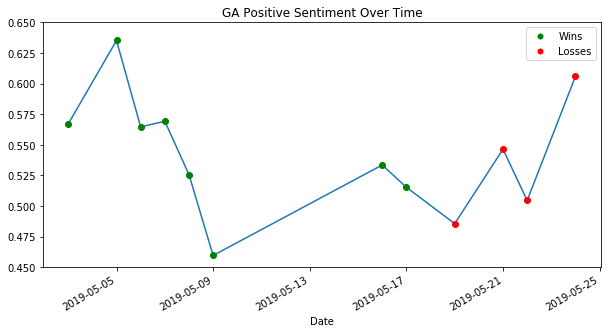

<Figure size 720x360 with 0 Axes>

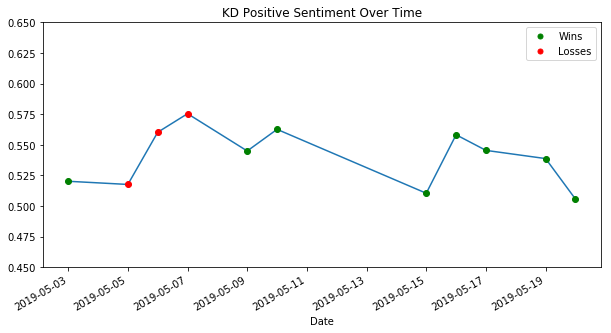

<Figure size 720x360 with 0 Axes>

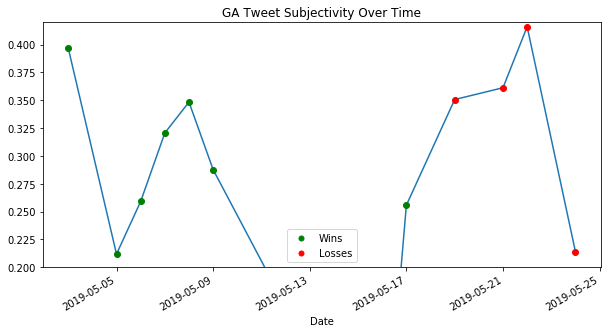

<Figure size 720x360 with 0 Axes>

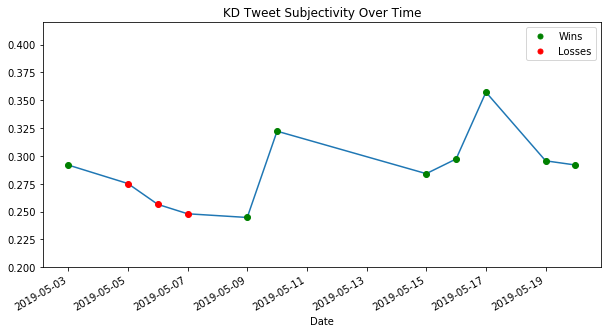

In [57]:
#Line plots for sentiment over time

#GA plot
plt.rcParams['figure.figsize'] = [10, 5]
f1 = plt.figure()
ga_df.plot.line(x = 'Date', y = 'pos_sentiment')
ga_sent_winsx = ga_df[ga_df['result']=='W'].Date
ga_sent_winsy = ga_df[ga_df['result'] == 'W'].pos_sentiment
ga_sent_lossx = ga_df[ga_df['result']=='L'].Date
ga_sent_lossy = ga_df[ga_df['result'] == 'L'].pos_sentiment
wins = plt.plot(ga_sent_winsx,ga_sent_winsy,'go')
loss = plt.plot(ga_sent_lossx,ga_sent_lossy,'ro')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                          markersize=5, label='Wins')
red_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=5, label='Losses')
plt.legend(handles=[green_circle, red_circle])
plt.title('GA Positive Sentiment Over Time')
plt.ylim(top = 0.65, bottom = 0.45)

#KD plot
f2 = plt.figure()
kd_df.plot.line(x = 'Date', y = 'pos_sentiment')
kd_sent_winsx = kd_df[kd_df['result']=='W'].Date
kd_sent_winsy = kd_df[kd_df['result'] == 'W'].pos_sentiment
kd_sent_lossx = kd_df[kd_df['result']=='L'].Date
kd_sent_lossy = kd_df[kd_df['result'] == 'L'].pos_sentiment
wins = plt.plot(kd_sent_winsx,kd_sent_winsy,'go')
loss = plt.plot(kd_sent_lossx,kd_sent_lossy,'ro')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                          markersize=5, label='Wins')
red_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=5, label='Losses')
plt.legend(handles=[green_circle, red_circle])
plt.title('KD Positive Sentiment Over Time')
plt.ylim(top = 0.65, bottom = 0.45)


#Line plots for subjectivity over time

#GA plot
f3 = plt.figure()
ga_df.plot.line(x = 'Date', y = 'subjectivity')
ga_subj_winsx = ga_df[ga_df['result']=='W'].Date
ga_subj_winsy = ga_df[ga_df['result'] == 'W'].subjectivity
ga_subj_lossx = ga_df[ga_df['result']=='L'].Date
ga_subj_lossy = ga_df[ga_df['result'] == 'L'].subjectivity
wins = plt.plot(ga_subj_winsx,ga_subj_winsy,'go')
loss = plt.plot(ga_subj_lossx,ga_subj_lossy,'ro')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                          markersize=5, label='Wins')
red_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=5, label='Losses')
plt.legend(handles=[green_circle, red_circle])
plt.title('GA Tweet Subjectivity Over Time')
plt.ylim(top = 0.42, bottom = 0.2)

#KD plot
f4 = plt.figure()
kd_df.plot.line(x = 'Date', y = 'subjectivity')
kd_subj_winsx = kd_df[kd_df['result']=='W'].Date
kd_subj_winsy = kd_df[kd_df['result'] == 'W'].subjectivity
kd_subj_lossx = kd_df[kd_df['result']=='L'].Date
kd_subj_lossy = kd_df[kd_df['result'] == 'L'].subjectivity
wins = plt.plot(kd_subj_winsx,kd_subj_winsy,'go')
loss = plt.plot(kd_subj_lossx,kd_subj_lossy,'ro')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                          markersize=5, label='Wins')
red_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=5, label='Losses')
plt.legend(handles=[green_circle, red_circle])
plt.title('KD Tweet Subjectivity Over Time')
plt.ylim(top = 0.42, bottom = 0.2)



For reference, these are the dates that the Warriors (KD) and the Bucks (GA) played games, and the outcomes of those games (These dates are also marked on the graph):

Dates of warrior games:
4/21 -- WIN,
4/24 -- LOSS,
4/26 -- WIN,
4/28 -- WIN,
4/30 -- WIN,
5/4 -- LOSS,
5/6 -- LOSS,
5/8 -- WIN,
5/10 -- WIN,
5/14 -- WIN,
5/16 -- WIN,
5/18 -- WIN,
5/20 -- WIN

Dates of bucks games:
4/20 -- WIN,
4/22 -- WIN,
4/28 -- LOSS,
4/30 -- WIN,
5/3 -- WIN,
5/6 -- WIN,
5/8 -- WIN,
5/15 -- WIN,
5/17 -- WIN,
5/19 -- LOSS,
5/21 -- LOSS

The graphs don't seem to show that much information at first glance, but there are a few dates of interest that can be observed on the graphs. First Giannis had relatively low positive sentiment on 5/9, despite the Bucks winning against the Celtics the night before, and eliminating them from the playoffs. This may have been caused by angry Celtics fan, or it may have simply been because we did not gather enough tweets for those days. Second, Giannis had another night of low positive sentiment on 5/19, when the Bucks lost for the first time against the Raptors in the Eastern Conference Finals after starting 2-0. Giannis played particularly poor that night, being held to a playoff-low 12 points. The low sentiment could possibly have been attributed to both the loss and Giannis's performance that night. 

The most interesting night to take note of for KD would've been 5/8, when he was injured in the Warrior's win against the Rockets. However, we were unable to collect any tweets on that night. KD has not played in any games since his injury, and the graph shows a relatively stable trend in positive sentiment over time. 


The next method we used to visualize our data was to create boxplots of the positive sentiment of tweets for each player on a given day, depending on whether their team won or loss on that day (or in the days between games). 

To do this, we create a new dataframe containing all of the relevant data for the boxplots. First, we drop the neg_sentiment, polarity, subjectivity, and num_tweets columns from the dataframes for each player. Next, we add a new column to each dataframe to specify which player each row represents, and then we append the two dataframes into one dataframe containing data for both players. Finally, we graph the positive sentiment in boxplots, grouping the data by player and by game outcome. 

Text(0.5, 1.0, 'Positive Sentiment Boxplot')

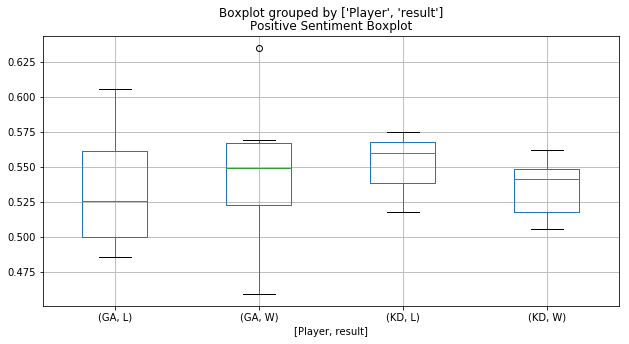

In [54]:
#Drop irrelevant columns
ga_boxdf = ga_df.drop(columns = ['neg_sentiment', 'polarity', 'subjectivity',
                                 'num_tweets'])
kd_boxdf = kd_df.drop(columns = ['neg_sentiment', 'polarity', 'subjectivity',
                                 'num_tweets'])

#Add Player column to indicate which rows correspond to which player
ga_boxdf['Player']='GA'
kd_boxdf['Player']='KD'

#Combine dataframes
boxplot_df = ga_boxdf.append(kd_boxdf)

#Boxplot grouped by player and result
f6 = boxplot_df.boxplot(by = ['Player', 'result'])
f6.set_title('Positive Sentiment Boxplot')

The boxplots show us that Giannis's tweets have a wider distribution of positive sentiment (in both wins and losses), while KD's tweets have a tighter distribution, regardless of win or loss. This difference may have been because we had much more tweets for KD than we did for Giannis, causing the quartiles for KD to close in towards the median. The median for Giannis's losses is lower than the median for his wins, while the opposite is true for KD. However, it is interesting to note that the median for KD's losses is actually the highest out of all medians. 

The final method we used to visualize our twitter sentiment data was to find the average positive sentiment on nights of wins and on nights of losses, as well as average positive sentiment across all games. These graphs would let us see if there were any easily noticable differences in average sentiment depending on whether each player's team won or loss. 

In [31]:
#GA sentiment based on win/loss
ga_win_sentiment = []
ga_loss_sentiment = []
for i in ga_df.index:
    outcome = ga_df.loc[i, 'result']
    if (outcome == 'W'):
        ga_win_sentiment.append(ga_df.loc[i, 'pos_sentiment'])
    if (outcome == 'L'):
        ga_loss_sentiment.append(ga_df.loc[i, 'pos_sentiment'])

ga_avg_win = sum(ga_win_sentiment)/len(ga_df[ga_df['result']=='W'])
ga_avg_loss = sum(ga_loss_sentiment)/len(ga_df[ga_df['result']=='L'])


#KD sentiment based on win/loss
kd_win_sentiment = []
kd_loss_sentiment = []
for i in kd_df.index:
    outcome = kd_df.loc[i, 'result']
    if (outcome == 'W'):
        kd_win_sentiment.append(kd_df.loc[i, 'pos_sentiment'])
    if (outcome == 'L'):
        kd_loss_sentiment.append(kd_df.loc[i, 'pos_sentiment'])

kd_avg_win = sum(kd_win_sentiment)/len(kd_df[kd_df['result']=='W'])
kd_avg_loss = sum(kd_loss_sentiment)/len(kd_df[kd_df['result']=='L'])


#Average sentiment across all games 
ga_avg_sent = sum(ga_df['pos_sentiment'])/len(ga_df['pos_sentiment'])
kd_avg_sent = sum(kd_df['pos_sentiment'])/len(kd_df['pos_sentiment'])



print('GA average sentiment across all games: ', ga_avg_sent)
print('GA average sentiment in wins: ', ga_avg_win)
print('GA average sentiment in losses: ', ga_avg_loss)
print('KD average sentiment across all games: ', kd_avg_sent)
print('KD average sentiment in wins: ', kd_avg_win)
print('KD average sentiment in losses: ', kd_avg_loss)

GA average sentiment across all games:  0.5426634741636542
GA average sentiment in wins:  0.546217186879
GA average sentiment in losses:  0.535556048733
KD average sentiment across all games:  0.539907526638455
KD average sentiment in wins:  0.535733191708
KD average sentiment in losses:  0.551039086452


The above codes shows average positive sentiment across all games, and then average sentiment across games where the player's team won or loss. 

After finding the average values, we graph them with a grouped bar plot. 

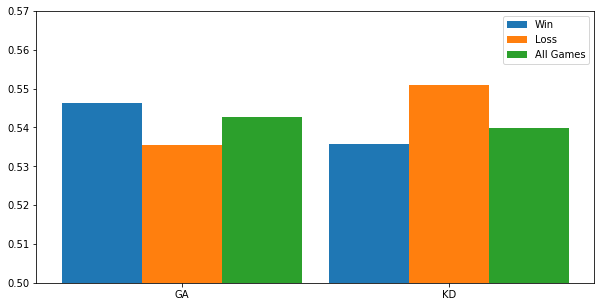

In [32]:
#Plot average sentiments
f5 = plt.figure()
barWidth = .3
plt.ylim(top = .57)
plt.ylim(bottom = .5)
win_bars = [ga_avg_win, kd_avg_win]
loss_bars = [ga_avg_loss, kd_avg_loss]
all_bars = [ga_avg_sent, kd_avg_sent]

r1 = np.arange(len(win_bars))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, win_bars, width = barWidth, label = 'Win')
plt.bar(r2, loss_bars, width = barWidth, label = 'Loss')
plt.bar(r3, all_bars, width = barWidth, label = 'All Games')
plt.xticks([r + barWidth for r in range(len(win_bars))], ['GA', 'KD'])


plt.legend()
plt.show()

The bars for Giannis show what we would expect from our twitter data: positive sentiment being higher on nights of wins, and lower on nights of losses. However, the bars for KD are the opposite. His positive sentiment on nights of wins is much lower than on nights of losses. This may have to do with the highly polar attitude towards Kevin Durant in general. Many fans of teams besides the Warriors dislike him, and may still tweet negatively about him even when he wins. Also, KD performed well during the playoffs even in losses, so fans may have still praised him even on nights when the Warriors lost. 

Note: The difference in these averages are still quite small (around 0.1-0.2)

## DATA Analysis and Results

When our team made the plan, we noticed that winning or losing for an NBA team had an impact on the twitter's overall sentiment especially for the two basketball players Kevin Durant and Giannis Antetokounmpo. To test our hunch, we collected thousands of related data about those two basketball teams from twitter over the span of one month. Our hypothesis was that the trend we would expect to observe is that on days where the player's team wins, the sentiment should be positive and on days where their team loses the sentiment should be negative. Therefore, we collected data from twitter and did the data visualization to examine our hypothesis.
    
After data cleaning and data processing, we created a table to show the positive and negative sentiment percentage for each basketball game. Even though the table could show the relationship between sentiment and winning, we still made several graphs to describe the relationship. From the graph, we showed the relationship between each team winning and the sentiment value of tweets. From the GA positive sentiment over time graph, it doesn't show a clear reationship between positive sentiment and the game result. The relationship looks somewhat random. Both losing and winning results could cause the higher positive sentiment. Furthermore, winning a game may cause a lower precentage of positive sentiment. However, from the KD positive sentiment over time graph, it also doesn't show a clear relationship between positive sentiment and the game result. The graph shows that whenever KD wins a game or loses a game, the precentage of positive sentiment always seems high(more than 50%). And we keep tracking and analyzing the dataset by the boxplot. The boxplots show us that Giannis's tweets have a wider distribution of positive sentiment whenever winning or losing a game. KD's tweets have a tighter distribution, as there is no relationship of win or loss. This difference may have been because we had many more tweets for KD than we did for Giannis, causing the quartiles for KD to close in towards the median. The median for Giannis's losses is lower than the median for his wins, while the opposite to be true for KD. However, it is interesting to note that the median for KD's losses is actually the highest out of all medians. And then, we use the bar graph to do analysis, there is clear relationship between the sentiment and game result. For GA team, the winning game has the higher persentage then losing a game. Therefore, fans or poeple would be willing to see winning of GA, but both game results have a high percentage of positive sentiment. It seems evident that GA is a more popular player than KD. And for KD's team, the losing games have a higher sentiment than the winning games. And also both game results have a high percentage of positive sentiment. But it seems that when KD loses a game, most people have a positive sentiment on twitter. 

In conclusion, from the data analysising, our hypothesis is wrong which is that the trend we would expect to observe is that on days where the player's team wins, the sentiment should be positive and on days where their team loses the sentiment should be negative. Therefore, there is no relationship between game result and positive sentiment from the twitter users according to our data.

## Ethical Considerations

One of the main ethical considerations involved with this project is that the data we have is biased towards people who have and use a twitter account. We are missing the sentiment of all people who don't have a twitter account, or even people who do, but don't tweet/include hashtags in their tweets. Including the sentiment of these groups might affect our final results. 

Another consideration is how the results of our analysis might affect the livelihood of these players. Since our analysis can be used to infer how popular a player is, our results could potentially be used by teams when offering one of these players a new contract. A player with higher sentiment might be able to demand more money, as a higher sentiment might suggest more fans. A player with a lower sentiment might potentially lose out on some money, as the team signing them could argue that less fans like them, and so they are therefore less valuable. 

Finally, we feel like the privacy of tweeters involved in this project is fairly well protected. Each of the tweets we collected is anonymous, with no label to identify the person who tweeted it. 

## Conclusions / Discussions

As discussed in our data analysis, we saw a weak relationship between the sentiment value of tweet's about a basketball player and the results of their games. One of the factors that could have most likely skewed our results started at data collection. 

The tweets we pulled from twitter were limited to a couple thousand per player. We could have pulled more tweets if we each used a different access token. This way we would less quickly reach the maximum limit of tweets that Twitter allows us to search for. Another important step in data collection that we could improve on next time is to filter the data we are receving. TextBlob API and Twitter API gives us different methods that we could have used to get more significant data. We could have used Twiiter's API to search for only English tweets since TextBlob could only analyze english words. We could have also used TextBlob's API to filter out stopwords. After doing this we may have been able to see better results.  

Another factor that we could not control is that Kevin Durant was injured during one of his games. After his injury he did not participate in any future games. That means that the results of certain games had nothing to do with his participation and the sentiment of his tweets would did not depend on his performance during the games. To further improve our results the next time we analyze the sentiment of tweets about a basketball player, we could prepare more data in advance in case a player gets injured and filter the data we reveive to get more sentimental value out of each string of words. 